In [26]:
import matplotlib
import numpy
import pandas as pd

# step 1: building the index

In [ ]:
bowtie2-build chr19.fa bowtie_index/chr19

# step 2: map the reads back to the genome, make bam files

In [ ]:
for sample in CTCF_ER4 CTCF_G1E input_ER4 input_G1E
do
  bowtie2 -x ../bowtie_index/chr19 -U ${sample}.fastq -S ${sample}.sam -p 6
  samtools view -bSo ${sample}.bam ${sample}.sam
  samtools sort ${sample}.bam -o ${sample}.sorted.bam
  samtools index ${sample}.sorted.bam
done

# step 3: Calling peaks

In [ ]:
macs2 callpeak -t CTCF_ER4.bam  -c input_ER4.bam --format=BAM --name=ER4 --gsize=61000000 --tsize=36

In [ ]:
macs2 callpeak -t CTCF_G1E.bam  -c input_G1E.bam --format=BAM --name=G1E --gsize=61000000 --tsize=36

# step 4: differential binding

G1E is before differentiation
ER4 is after differentiation
so the -v flag tells me what is in A that is NOT in B. 
so if i want to find out what is gained:
    I have to do ER4 as A and G1E as B
and if i want to find out what is lost:
    I have to do G1E as A and ER4 as B


In [ ]:
bedtools intersect -v -a ER4_peaks.narrowPeak -b G1E_peaks.narrowPeak > gain.bed

In [ ]:
bedtools intersect -v -a G1E_peaks.narrowPeak -b ER4_peaks.narrowPeak > loss.bed

# step 5: Feature overlapping

-wa	Write the original entry in A for each overlap.


ok so you dummy we want the complete region in G1e or ER4 at each place that it overlaps with a feature on the other file that has the features (opening the file reveals that 'features' means introns, exons, promoters etc)


but which of the ER/G1 files do i want to use here?

Im thinking that I should use the ER4_peaks.narrowPeak because I only want the places in the sample where CTCF was binding

In [ ]:
bedtools intersect -wa -a Mus_musculus.GRCm38.94_features.bed -b G1E_peaks.narrowPeak | cut -f 4 | sort | uniq -c > overlap_G1E.bed
bedtools intersect -wa -a Mus_musculus.GRCm38.94_features.bed -b ER4_peaks.narrowPeak | cut -f 4 | sort | uniq -c > overlap_ER4.bed

In [ ]:
Results from above step:
G1E:
    84 exon
    307 intron
    54 promoter
ER4:
    101 exon
    341 intron
    67 promoter

In [27]:
features = ('exon','intron','promoter')
y_pos = numpy.arange(len(features))
G1E_val = [84, 307, 54]

In [28]:
matplotlib.axes.Axes.barh(y_pos, G1E_val, width = 0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('How fast do you want to go today?')

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

In [ ]:
people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
y_pos = np.arange(len(people))
performance = 3 + 10 * np.random.rand(len(people))
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('How fast do you want to go today?')

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'barh'

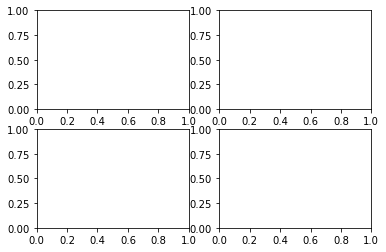

In [36]:
features = ('exon','intron','promoter')
y_pos = (0,1,2)
G1E_val = (84, 307, 54)






fig, ax = plt.subplots( 2,2 )
ax[0].barh(G1E_val, y_pos, width = 0.8)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(features)




ax[1].barh()
ax[2].barh()
ax[3].barh()
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots( 1,3 )
ax[0].bar( coi2, chr_k4.loc[ coi2 ] )
ax[0].set_xlabel("Location")
ax[0].set_ylabel("Number of Hits")
ax[0].set_title("Lys 4")
ax[0].set_ylim(0, 950)
ax[1].bar( coi2, chr_k9.loc[ coi2 ] )
ax[1].set_xlabel("Location")
ax[1].set_ylabel("Number of Hits")
ax[1].set_title("Lys 9")
ax[1].set_ylim(0, 950)
ax[2].bar( coi2, chr_k27.loc[ coi2 ] )
ax[2].set_xlabel("Location")
ax[2].set_ylabel("Number of Hits")
ax[2].set_title("Lys 27")
ax[2].set_ylim(0, 950)
fig.tight_layout()

In [ ]:
# part 2: Motif discovery

In [ ]:
## step 1: downlead meme motif databases and finding only 100 strongest peaks

In [ ]:
sort -k 5 -n ER4_peaks.narrowPeak | tail -n 100 > sortedER4_peaks